In [2]:
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nb
import nibabel.freesurfer.mghformat as mgh
from nibabel.freesurfer.io import read_geometry
from nilearn.plotting.surf_plotting import load_surf_data
import myvis
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM

### 0. get data demographics with pandas

In [3]:
datadir = '../data'

dfname = os.path.join(datadir, 'thickness.csv')
df = pd.read_csv(dfname)

idx = np.array(df["ID2"])
age = np.array(df["AGE"])
iq = np.array(df["IQ"])



### 1. load thickness data 

In [4]:
j = 0
for Sidx in idx:
    
    # load mgh files for left hem 
    for file_L in glob.glob('../data/thickness/%s*_lh2fsaverage5_20.mgh' 
                            % (Sidx)):
        
        S_Lmgh = mgh.load(file_L).get_fdata()
        S_Larr = np.array(S_Lmgh)[:,:,0]
        
    # load mgh files for right hem        
    for file_R in glob.glob('../data/thickness/%s*_rh2fsaverage5_20.mgh' 
                            % (Sidx)):
        
        S_Rmgh = mgh.load(file_R).get_fdata()
        S_Rarr = np.array(S_Rmgh)[:,:,0]

    # concatenate left & right thickness for each subject    
    Sidx_thickness = np.concatenate((S_Larr, S_Rarr)).T

    if j == 0:
        thickness = Sidx_thickness
    else:
        thickness = np.concatenate((thickness, Sidx_thickness), axis=0)
    j += 1        

In [5]:
Mean_thickness = thickness.mean(axis=0)
print("all thicknes data loaded shape: ", thickness.shape)
print("Mean thickness shape: ", Mean_thickness.shape)


all thicknes data loaded shape:  (259, 20484)
Mean thickness shape:  (20484,)


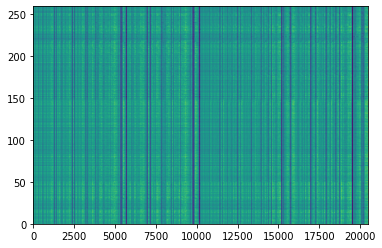

In [6]:
fig01 = plt.imshow(thickness, extent=[0,20484,0,259], aspect='auto')


### 2. plot mean thickness along the cortex

In [7]:
Fs_Mesh_L = read_geometry(os.path.join(datadir, 'fsaverage5/lh.pial'))
Fs_Mesh_R = read_geometry(os.path.join(datadir, 'fsaverage5/rh.pial'))

Fs_Bg_Map_L  = load_surf_data(os.path.join(datadir, 'fsaverage5/lh.sulc'))
Fs_Bg_Map_R = load_surf_data(os.path.join(datadir, 'fsaverage5/rh.sulc'))

Mask_Left  = nb.freesurfer.io.read_label((os.path.join(
        datadir,'fsaverage5/lh.cortex.label')))
Mask_Right = nb.freesurfer.io.read_label((os.path.join(
        datadir,'fsaverage5/rh.cortex.label')))

surf_mesh = {}
surf_mesh['coords'] = np.concatenate((Fs_Mesh_L[0], Fs_Mesh_R[0]))
surf_mesh['tri']    = np.concatenate((Fs_Mesh_L[1], Fs_Mesh_R[1]))
bg_map = np.concatenate((Fs_Bg_Map_L, Fs_Bg_Map_R))
medial_wall = np.concatenate((Mask_Left,  10242 + Mask_Right))


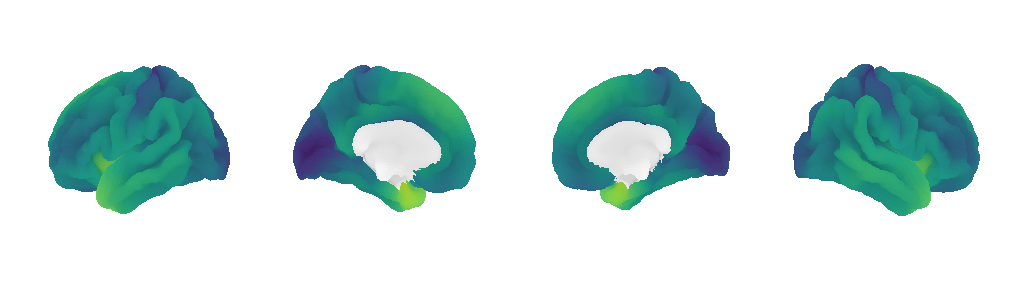

In [8]:
fig02 = myvis.plot_surfstat(surf_mesh, bg_map, Mean_thickness, 
                            mask = medial_wall,
                            cmap = 'viridis', vmin = 1.5, vmax = 4)

### 3. build the stats model

In [9]:
term_intercept = FixedEffect(1, names="intercept")
term_age = FixedEffect(age, "age")
term_iq = FixedEffect(iq, "iq")
model = term_intercept + term_age 

slm = SLM(model, -age, surf=surf_mesh)
slm.fit(thickness)
tvals = slm.t.flatten()
pvals = slm.fdr()

print("t-values: ", tvals)  # These are the t-values of the model.
print("p-values: ", pvals)  # These are the p-values of the model.


t-values:  [ 3.70352445  9.00643325 11.51625374 ...  2.42269373  2.80816754
  3.23542035]
p-values:  [1.70069476e-04 8.81888145e-17 5.71164388e-24 ... 9.66039843e-03
 3.29548858e-03 8.66342267e-04]


/home/sheyma/usr/lib/python3.6/site-packages/brainstat-0.0.3-py3.6.egg/brainstat/stats/_linear_model.py:422: RuntimeWarning: invalid value encountered in true_divide
  u = Y[i, :, j] / normr


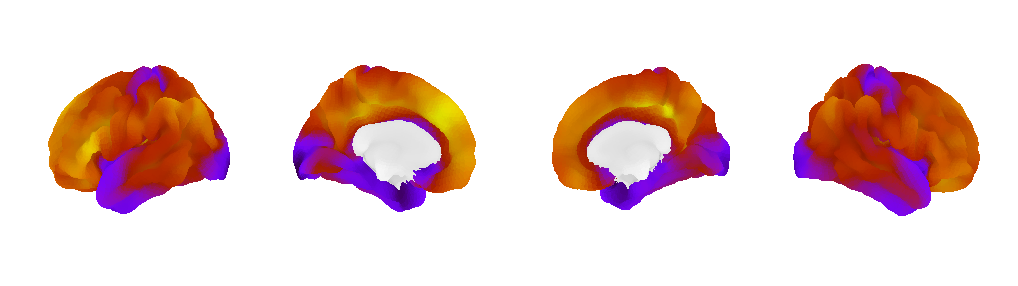

In [10]:
fig03 = myvis.plot_surfstat(surf_mesh, bg_map, tvals,
                            mask = medial_wall, cmap = 'gnuplot',
                            vmin = tvals.min(), vmax = tvals.max())



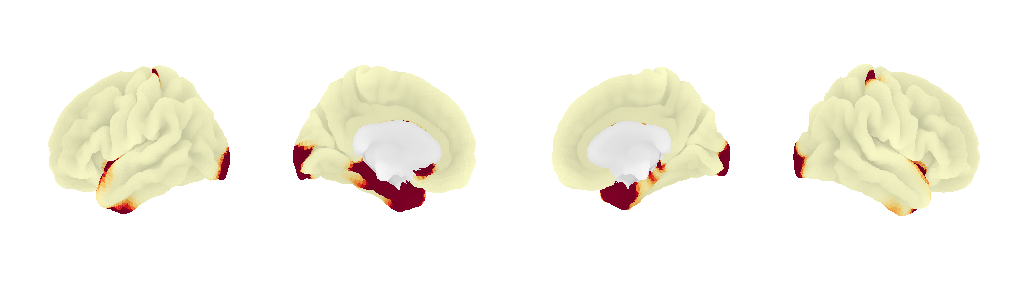

In [11]:
fig04 = myvis.plot_surfstat(surf_mesh, bg_map, pvals,
                            mask = medial_wall, cmap = 'YlOrRd',
                            vmin = 0, vmax = 0.05)
